In [12]:
import catboost as cb
import pandas as pd
import numpy as np
import sys

sys.path.append('/home/sultanan/energy')
from energy_pred import (
    GicaHackDataLoader,
)

In [2]:
loaded_model = cb.CatBoostRegressor()
model_path = "/home/sultanan/energy/notebooks/catboost_models/energy_forecast_model.cbm"
# Then, load the saved state into the new instance.
print(f"\nLoading model from: {model_path}")
loaded_model.load_model(model_path)


Loading model from: /home/sultanan/energy/notebooks/catboost_models/energy_forecast_model.cbm


In [3]:

DATA_DIR = '/home/sultanan/datasets/energy/GicaHack'
loader = GicaHackDataLoader(DATA_DIR, verbose=True)
loader.load()
raw_df = loader.get_raw()

Skipping empty file: 03.06.2025 06_00_All measuring points_ExportFile.csv
Skipping empty file: 03.06.2025 18_01_All measuring points_ExportFile.csv
Skipping empty file: 04.06.2025 06_00_All measuring points_ExportFile.csv
Concatenated shape: (2254330, 5)


In [4]:
def preprocess_and_normalize_consumption(raw_df):
    """
    Normalizes raw smart meter data by distributing accumulated consumption
    over a consistent 15-minute frequency, then aggregates to a final
    hourly median across all meters.

    Args:
        raw_df (pd.DataFrame): DataFrame with columns ['timestamp', 'meter', 'import_diff']
                               where 'timestamp' can have variable time gaps.

    Returns:
        pd.DataFrame: A DataFrame indexed by the hour, with a single column
                      containing the median hourly energy consumption.
    """
    # Ensure timestamp column is in datetime format
    raw_df['timestamp'] = pd.to_datetime(raw_df['timestamp'])

    def normalize_meter_data(df_meter):
        """
        Processes data for a single meter. This function is intended to be
        used with pandas' .groupby().apply().
        """
        # Set timestamp as index and sort to ensure correct time delta calculation
        df_meter = df_meter.sort_values('timestamp').set_index('timestamp')

        # FIX: Aggregate duplicate timestamps before resampling
        if df_meter.index.has_duplicates:
            df_meter = df_meter.groupby(df_meter.index).mean()

        # 1. Calculate time difference (in minutes) between consecutive readings
        time_deltas = df_meter.index.to_series().diff().dt.total_seconds() / 60.0

        # 2. Determine how many 15-minute "bins" each reading represents
        num_bins = (time_deltas / 15.0).fillna(1).replace(0, 1)

        # 3. Normalize the consumption by the number of bins
        df_meter['normalized_diff'] = df_meter['import_diff'] / num_bins

        # 4. Resample to a consistent 15-minute frequency and forward-fill
        df_resampled = df_meter[['normalized_diff']].resample('15min').ffill()
        
        return df_resampled

    print("Step 1: Normalizing data for each meter to a 15-minute frequency...")
    df_normalized = raw_df.groupby('meter').apply(normalize_meter_data)

    print("Step 2: Aggregating to final hourly median...")
    df_normalized = df_normalized.reset_index()
    
    # --- MODIFIED LOGIC STARTS HERE ---
    
    df_normalized = df_normalized.set_index('timestamp')
    
    # Step A: Discretize to hourly data for EACH meter by SUMMING the 15-min values.
    # This calculates the total consumption for each hour for each meter.
    df_hourly_per_meter = df_normalized.groupby('meter').resample('H')['normalized_diff'].sum()
    
    # Reset the index so we can group by the hourly timestamp
    df_hourly_per_meter = df_hourly_per_meter.reset_index()
    
    # Step B: Finally, get the median of these hourly consumptions across all meters.
    df_final = df_hourly_per_meter.groupby('timestamp')['normalized_diff'].median()
    
    # --- MODIFIED LOGIC ENDS HERE ---
    
    # Return as a DataFrame with a clear column name
    return df_final.to_frame(name='import_diff')

In [5]:

def create_advanced_features(df):
    """
    Создает расширенные признаки из временного ряда с исправленной логикой
    для категориальных переменных.
    """
    df = df.copy()
    
    # --- ИСПРАВЛЕННАЯ ЛОГИКА ДЛЯ ВРЕМЕННЫХ ПРИЗНАКОВ ---
    
    # 1. Сначала извлекаем временные компоненты как ЧИСЛА
    hour = df.index.hour
    day_of_week = df.index.dayofweek  # 0=понедельник, 6=воскресенье
    month = df.index.month
    
    # 2. Выполняем числовое сравнение для создания 'is_weekend'
    is_weekend = (day_of_week >= 5).astype(int) # 1 для выходного, 0 для буднего
    
    # 3. Создаем остальные временные признаки
    df['hour'] = hour
    df['day_of_week'] = day_of_week
    df['is_weekend'] = is_weekend
    df['month'] = month
    df['season'] = (month % 12 + 3) // 3  # 1=весна, 2=лето, 3=осень, 4=зима
    
    # 4. Теперь, когда все вычисления завершены, преобразуем в категориальный тип
    # Это хорошая практика для CatBoost.
    for col in ['hour', 'day_of_week', 'is_weekend', 'month', 'season']:
        df[col] = df[col].astype('category')
        
    # --- КОНЕЦ ИСПРАВЛЕННОЙ ЛОГИКИ ---

    # Лаговые признаки (значения за предыдущие периоды)
    for lag in [1, 2, 3, 24, 48, 168]:  # 1-3 часа, сутки, двое суток, неделя
        df[f'import_lag_{lag}'] = df['import_diff'].shift(lag)
    
    # Скользящие статистики
    windows = [4, 8, 24, 72]  # 4 часа, 8 часов, сутки, трое суток
    for window in windows:
        df[f'rolling_mean_{window}'] = df['import_diff'].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'rolling_std_{window}'] = df['import_diff'].shift(1).rolling(window=window, min_periods=1).std()
        df[f'rolling_max_{window}'] = df['import_diff'].shift(1).rolling(window=window, min_periods=1).max()
    
    # Признаки на основе погоды
    df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
    df['comfort_index'] = df['temperature'] - 0.55 * (1 - df['humidity']/100) * (df['temperature'] - 14.5)
    # weather rolling mean, std
    for window in [3, 6, 12]:  # 3 часа, 6 часов, 12 часов
        for feature in ['temperature', 'humidity', 'pressure']:
            df[f'{feature}_rolling_mean_{window}'] = df[feature].shift(1).rolling(window=window, min_periods=1).mean()
            df[f'{feature}_rolling_std_{window}'] = df[feature].shift(1).rolling(window=window, min_periods=1).std()

    # Для периодических признаков используем синусоиды
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'].astype(int) / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'].astype(int) / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'].astype(int) / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'].astype(int) / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(int) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(int) / 12)
    df['temperature_sin'] = np.sin(2 * np.pi * df['temperature'] / df['temperature'].max())
    df['temperature_cos'] = np.cos(2 * np.pi * df['temperature'] / df['temperature'].max())
    df['humidity_sin'] = np.sin(2 * np.pi * df['humidity'] / 100)
    df['humidity_cos'] = np.cos(2 * np.pi * df['humidity'] / 100)
    df['pressure_sin'] = np.sin(2 * np.pi * df['pressure'] / df['pressure'].max())
    df['pressure_cos'] = np.cos(2 * np.pi * df['pressure'] / df['pressure'].max())
    
    # Производные от давления
    df['pressure_change'] = df['pressure'].diff()
    df['pressure_trend'] = df['pressure'].rolling(window=6, min_periods=1).mean()
    
    # Удаляем строки с NaN (появились из-за лагов)
    df = df.dropna()
    
    return df



In [6]:
import requests
def add_weather_features(df, lat=47.01, lon=28.86, tz='Europe/Chisinau'):
    df = pd.DataFrame(df)  # Ensure df is a DataFrame
    """Enriches a DataFrame with historical weather data from Open-Meteo."""
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DatetimeIndex.")
    
    start_date = df.index.min().strftime('%Y-%m-%d')
    end_date = df.index.max().strftime('%Y-%m-%d')
    print(f"Fetching weather data for Chișinău from {start_date} to {end_date}...")
    
    api_url = (
        "https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}&start_date={start_date}&end_date={end_date}"
        "&hourly=temperature_2m,relative_humidity_2m,surface_pressure"
        f"&timezone={tz}"
    )
    response = requests.get(api_url)
    response.raise_for_status() # Raises an exception for bad status codes
    
    weather_data = response.json()
    df_weather = pd.DataFrame(data=weather_data['hourly'])
    df_weather['time'] = pd.to_datetime(df_weather['time'])
    df_weather = df_weather.set_index('time').rename(columns={
        'temperature_2m': 'temperature', 'relative_humidity_2m': 'humidity', 'surface_pressure': 'pressure'
    })
    
    df_merged = df.merge(df_weather, left_index=True, right_index=True, how='left')
    return df_merged


In [7]:
clean_df = preprocess_and_normalize_consumption(raw_df)

Step 1: Normalizing data for each meter to a 15-minute frequency...


/tmp/ipykernel_4192427/3239882581.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_normalized = raw_df.groupby('meter').apply(normalize_meter_data)


Step 2: Aggregating to final hourly median...


/tmp/ipykernel_4192427/3239882581.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly_per_meter = df_normalized.groupby('meter').resample('H')['normalized_diff'].sum()


In [8]:
clean_df = add_weather_features(pd.DataFrame(clean_df))

Fetching weather data for Chișinău from 2024-10-01 to 2025-06-08...


In [9]:
clean_df.head()

,import_diff,temperature,humidity,pressure
timestamp,,,,
2024-10-01 00:00:00,0.0,13.1,76,1004.1
2024-10-01 01:00:00,0.0,13.0,78,1004.2
2024-10-01 02:00:00,0.0,12.3,88,1004.3
2024-10-01 03:00:00,0.0,12.2,90,1003.7
2024-10-01 04:00:00,0.0,11.4,90,1004.3


In [13]:
df_enriched = create_advanced_features(clean_df)
print(f"Размер данных после feature engineering: {df_enriched.shape}")

X = df_enriched.drop('import_diff', axis=1)

Размер данных после feature engineering: (5848, 61)


In [15]:
y_pred = loaded_model.predict(X)

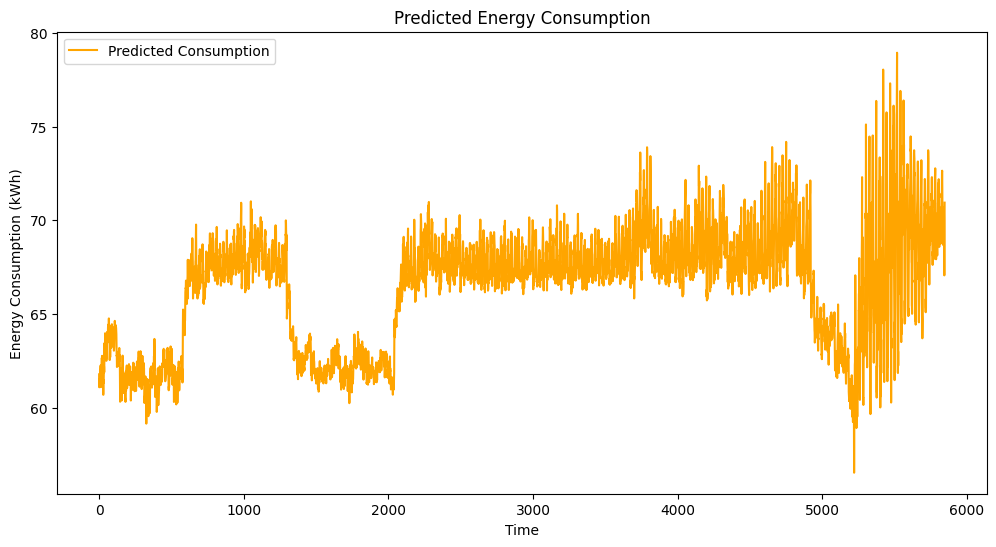

In [17]:
# plot y_pred
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_pred, label='Predicted Consumption', color='orange')
plt.title('Predicted Energy Consumption')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()

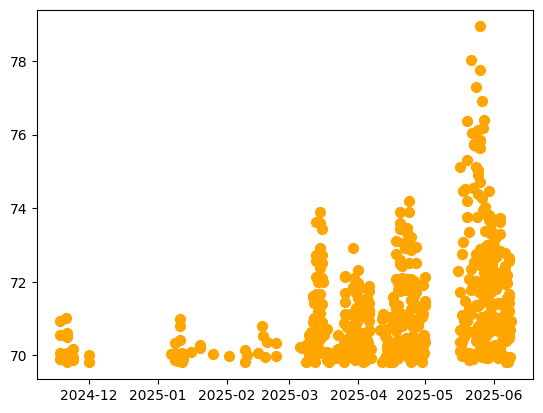

In [21]:
y_pred_pd = pd.Series(y_pred, index=X.index)
peak_threshold = y_pred_pd.quantile(0.9)
peak_indices = y_pred_pd[y_pred_pd > peak_threshold].index
plt.scatter(peak_indices, y_pred_pd[peak_indices], color='orange', s=50, 
           label=f'Пики (> {peak_threshold:.1f})', zorder=5)

In [2]:
import pandas as pd
import requests
def get_weather_forecast(future_steps: int, lat: float = 47.01, lon: float = 28.86, tz: str = 'Europe/Chisinau') -> pd.DataFrame:
    """
    Fetches hourly weather forecast data from Open-Meteo.
    """
    print(f"Fetching weather forecast for the next {future_steps} hours...")
    
    api_url = (
        "https://api.open-meteo.com/v1/forecast?"
        f"latitude={lat}&longitude={lon}&hourly=temperature_2m,relative_humidity_2m,surface_pressure"
        f"&forecast_hours={future_steps}&timezone={tz}"
    )
    response = requests.get(api_url)
    response.raise_for_status()
    
    weather_data = response.json()['hourly']
    df_weather = pd.DataFrame(data=weather_data)
    df_weather['time'] = pd.to_datetime(df_weather['time'])
    df_weather = df_weather.set_index('time').rename(columns={
        'temperature_2m': 'temperature', 
        'relative_humidity_2m': 'humidity', 
        'surface_pressure': 'pressure'
    })
    return df_weather



In [3]:
get_weather_forecast(24)

Fetching weather forecast for the next 24 hours...


,temperature,humidity,pressure
time,,,
2025-09-13 21:00:00,21.5,46,1019.9
2025-09-13 22:00:00,20.4,52,1020.0
2025-09-13 23:00:00,19.4,57,1020.5
2025-09-14 00:00:00,18.4,60,1020.4
2025-09-14 01:00:00,17.5,63,1020.9
2025-09-14 02:00:00,16.7,66,1020.9
2025-09-14 03:00:00,16.0,68,1020.8
2025-09-14 04:00:00,15.4,72,1020.3
2025-09-14 05:00:00,15.0,77,1020.1
